In [1]:
import pandas as pd
import numpy as np
import datetime

# !pip install scikit-surprise
# if that doesn't work and you have conda installed, run this in the anaconda command line:
# only if the second doesn't work: conda update -n base -c defaults conda
# conda install -c conda-forge/label/cf202003 scikit-surprise

from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split

from sklearn.cluster import KMeans
import gensim.downloader as api
import pgeocode
from sklearn.metrics import mean_squared_error

import itertools

pd.options.mode.chained_assignment = None  # default='warn'

### Regular SVD prediction

In [2]:
def denorm(rating, user):
    try:
        # rating = rating * (users_mean['rating'].loc[int(user)]+1e-5)
        rating = rating + (users_mean['rating'].loc[str(user)])
        
        return rating
    except Exception as E:
        return users_mean['rating'].mean()

def predict(algo, user, item):
    try:
        return algo.predict(str(user), str(item)).est
    except:
        return 3 # CHANGE!

In [3]:
df = pd.read_csv('ml-100k/ml-100k/u.data', sep="\t", names=[ 'user_id','item_id','rating','timestamp'])

In [4]:
df['timestamp'] = df['timestamp'].apply(datetime.datetime.fromtimestamp)
df.sort_values('timestamp', inplace=True)
users_mean = df[['rating','user_id']].groupby('user_id').mean()
# df['rating_norm'] = df[['user_id', 'rating']].apply(lambda x: x[1]-users_mean.loc[x[0]], axis=1)
# df['rating_norm'] = df[['user_id', 'rating']].apply(lambda x: x[1]/(users_mean.loc[x[0]]+1e-5), axis=1)

df['user_id'] = df['user_id'].astype(str)
df['item_id'] = df['item_id'].astype(str)
df = df[['user_id','item_id','rating']]
df.columns = ['user', 'item', 'rating']

In [5]:
val_size = int(0.15 * len(df))
test_size = int(0.15 * len(df))

df_train = df.iloc[:-(test_size+val_size)]
df_val = df.iloc[-(test_size+val_size):-test_size]
df_test = df.iloc[-test_size:]

users_train = df_train['user'].unique()
df_test['user_cold_start'] = (~df_test['user'].isin(users_train)).astype(int)
items_train = df_train['item'].unique()
df_test['item_cold_start'] = (~df_test['item'].isin(items_train)).astype(int)

df_test['cold_start_both'] = (df_test['user_cold_start']) & (df_test['item_cold_start'])
df_test['cold_start'] = (df_test['user_cold_start']) | (df_test['item_cold_start'])

In [6]:
indices = list(df_train.index)
np.random.shuffle(indices)
df_train = df_train.loc[indices,:]

In [7]:
df_train.to_csv('ml-100k.csv', index=False)

In [8]:
file_path = './ml-100k.csv'
reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)
# data.__dict__['raw_ratings']

In [9]:
# data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
# trainset, testset = train_test_split(data, test_size=.25)
trainset = data.build_full_trainset()

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

# Then compute RMSE
# accuracy.rmse(predictions)

In [10]:
# testset_eval = pd.DataFrame(testset, columns = ['user','item','rating'])
testset_eval = df_test.copy()
testset_eval['predictions'] = testset_eval[['user','item']].apply(lambda x: predict(algo, x['user'],x['item']), axis=1)
# testset_eval['predictions'] = testset_eval[['predictions','user']].apply(lambda x: denorm(x['predictions'], x['user']), axis=1)
# testset_eval['rating'] = testset_eval[['rating','user']].apply(lambda x: denorm(x['rating'], x['user']), axis=1)
print (mean_squared_error(testset_eval['rating'].values, testset_eval['predictions'].values))

1.0792395871724947


In [11]:
# testset_eval = pd.concat([testset_eval, df_test.reset_index()[['user_cold_start', 'item_cold_start', 'cold_start_both', 'cold_start']]], axis=1)
for cs in ['user_cold_start','item_cold_start','cold_start_both','cold_start']:
    print (mean_squared_error(testset_eval[testset_eval[cs]==1]['rating'].values, testset_eval[testset_eval[cs]==1]['predictions'].values))

1.0793810695060584
1.3788650338997008
1.451986637010326
1.079838098065875


In [12]:
print (mean_squared_error(testset_eval[testset_eval['cold_start']==0]['rating'].values, testset_eval[testset_eval['cold_start']==0]['predictions'].values))

1.0735379833987146


In [ ]:
# 1.3464711227621673, 1.05215604047015

#### outcomes (rmse):
##### trying to improve the simple SVD recommendation
reg dataset: ~9999
<br> with timestamp (sorted by date): ~0.95 
<br> normalized (substracted the user's ratings mean): ~2.05
<br> normalized (devided by the user's ratings mean): ~1.013

## Clustering functions

In [4]:
'''
movies_cols = ['movie id' , 'movie_title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western']
movies = pd.read_csv('ml-100k/ml-100k/u.item', sep="|", names=movies_cols, encoding='latin-1')

users_cols = ['user id','age','gender','occupation','zip code']
users = pd.read_csv('ml-100k/ml-100k/u.user', sep="|", names=users_cols)
'''

In [13]:
# create doc2vec function using w2v model

def doc2vec(text, model_wv, agg_func=np.mean):
    doc_val = np.array([0]*300, dtype='float64')
    word_vals = []
    try:
        words = text.split(' ')
    except:
        return doc_val
    for word in words:
        try:
            word_val = model_wv.get_vector(word)
            word_vals.append(word_val)
        except:
            continue
    if len(word_vals) == 0:
        return doc_val
    word_vals = np.stack(word_vals)
    doc_val = agg_func(word_vals, axis=0)
    return doc_val

def adjustTestColumns(test, train_columns):
    missing_cols = set( train_columns ) - set( test.columns )
    for c in missing_cols:
        test[c] = 0
    test = test[train.columns]
    return test

# preform doc-to-vec processing to both the song lyrics and name

In [39]:
def preprocess_movies(movies):
    movies['release_date'] = pd.to_datetime(movies['release_date'])
    movies['month'] = movies['release_date'].apply(lambda d: d.month)
    movies['dayofweek'] = movies['release_date'].apply(lambda d: d.dayofweek)
    movies['month'] = movies['month'].fillna(movies['month'].median()).astype('int')
    movies['dayofweek'] = movies['dayofweek'].fillna(movies['dayofweek'].median()).astype('int')
    df_month = pd.get_dummies(movies['month'], prefix='month')
    df_dayofweek = pd.get_dummies(movies['dayofweek'], prefix='dayofweek')
    movies = pd.concat([movies, df_month, df_dayofweek], axis=1)
    del df_month, df_dayofweek
    movies.drop(columns=['unknown', 'video_release_date','IMDb_URL', 'release_date', 'month','dayofweek',
                         'movie_title','title_doc2vec'], inplace=True)
    movies['movie id'] = movies['movie id'].astype(str)
    
    model = api.load("word2vec-google-news-300")
    agg_func = np.mean 
    movies['title_doc2vec'] = movies['movie_title'].apply(lambda s: doc2vec(s, model, agg_func=agg_func))
    doc2vec_col_names = [f'doc2vec_{i}' for i in range(300)]
    df_doc2vec = pd.DataFrame(data=np.stack(movies['title_doc2vec'].values), columns=doc2vec_col_names)
    df_doc2vec.to_csv('dataset_doc2vec_mean.csv')
    movies = pd.concat([movies, df_doc2vec], axis=1)
    return movies

In [22]:
def preprocess_users(users, norm=False, norm_max=None, norm_min=None):    
    users['gender'] = pd.get_dummies(users['gender'], drop_first='True')
    users = pd.concat([users.drop(columns='occupation'), pd.get_dummies(users['occupation'])], axis=1)

    nomi = pgeocode.Nominatim('us')
    loaction_data = users['zip code'].apply(lambda z: nomi.query_postal_code(z).loc[['state_code','latitude','longitude']])

    state_dummies = pd.get_dummies(loaction_data['state_code'])
    limit_state = 10
    state_dummies = state_dummies[[col for col in state_dummies if state_dummies[col].sum() > limit_state]]

    users = pd.concat([users.drop(columns=['zip code']), 
                        state_dummies,
                        loaction_data[['latitude','longitude']]], axis=1)

    # normalize numeric values:
    if norm:
        numeric_cols = ['age','latitude','longitude']
        if norm_max == None:
            norm_min = users[numeric_cols].min()
            norm_max = users[numeric_cols].max()

        users[numeric_cols] = (users[numeric_cols] - norm_min) / (norm_max - norm_min)
    users = users.fillna(users.mean())
    users['user id'] = users['user id'].astype(str)
    return users, norm_min, norm_max

## Cluster-based prediction

In [18]:
def defineCluster(element_id, clust_dict, clust_model, content):
    element_id = str(element_id)
    try:
        cluster = clust_dict[element_id]
    except:
        try:
            
            element_content = content[content.index == element_id].values.reshape(1,-1)
            cluster = clust_model.predict(element_content)[0]
        except Exception as E: 
            print ('element_id', element_id)
            print (E)
            print (element_content)
    return cluster
    
def getTrainClusterModels(movies_train, users_train, n_clusters_movies, n_clusters_users):
    kmeans_movies = KMeans(n_clusters=n_clusters_movies)#, algorithm="full")
    kmeans_movies.fit(movies_train.fillna(0).values)

    kmeans_users = KMeans(n_clusters=n_clusters_users)#, algorithm="full")
    kmeans_users.fit(users_train.fillna(0).values)

    return kmeans_users, kmeans_movies

def defineClusters(df, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies):
    df['user_cluster'] = df['user'].apply(lambda u: defineCluster(u, clust_dict=users_dict, clust_model=kmeans_users, 
                                                                             content=users)).astype(str)
    df['movie_cluster'] = df['item'].apply(lambda m: defineCluster(m, clust_dict=movies_dict, clust_model=kmeans_movies, 
                                                                             content=movies_)).astype(str)
    return df

def predict_clstr(algo, df_train_cluster, user, item):
    user = str(user)
    item = str(item)
    try:
        return df_train_cluster[(df_train_cluster['user'] == user) & (df_train_cluster['item'] == item)]['rating'].iloc[0]
    except :
        try:
            return algo.predict(str(user), str(item)).est
        except:
            return df_train_cluster['rating'].mean()
        
def round_close(pred, lim_min=0.1, lim_max=0.9):
    remainder = pred % 1
    if remainder > lim_max:
        return np.ceil(pred)
    if remainder < lim_min:
        return np.floor(pred)
    return pred

In [15]:
# movies = preprocess_movies(movies)
# users, _, _ = preprocess_users(users, norm_max=None, norm_min=None)
# movies.to_csv('movies.csv')
# users.to_csv('users.csv')
movies = pd.read_csv('movies.csv', index_col=0)
users = pd.read_csv('users.csv', index_col=0)

movies.index = movies.index.astype('str')
users.index = users.index.astype('str')

In [15]:
user_behavior_cols = list(users.columns[-8:])
# users = pd.concat([users.set_index('user id'), df.iloc[:-test_size][['user','rating']].groupby('user').describe()], axis=1)
# users = users.fillna(users.mean())
# movies = pd.concat([movies.set_index('movie id'), df.iloc[:-test_size][['item','rating']].groupby('item').describe()], axis=1)
# movies = movies.fillna(movies.mean())

In [16]:
movies = movies.drop(columns=user_behavior_cols)
users = users.drop(columns=user_behavior_cols)

movies_train = movies[movies.index.isin(df_train['item'].values)]
users_train = users[users.index.isin(df_train['user'].values)]

In [17]:
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore

### playground example

In [335]:
for n_clusters_users in [25]:#range(15,41, 5):
    for n_clusters_movies in [35]:# range(15,41, 5):
        print (n_clusters_users, n_clusters_movies)
        kmeans_users, kmeans_movies = getTrainClusterModels(movies_train, users_train, n_clusters_movies, n_clusters_users)
        users_dict = dict(zip(users_train.index.values,kmeans_users.labels_))
        movies_dict = dict(zip(movies_train.index.values,kmeans_movies.labels_))
        
        df_train = defineClusters(df_train, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies)
        df_test = defineClusters(df_test, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies)
        df_val = defineClusters(df_val, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies)
        
        df_train_cluster = df_train[['user_cluster','movie_cluster','rating']].groupby(['user_cluster','movie_cluster']).mean().reset_index()
        df_train_cluster = df_train_cluster[['user_cluster','movie_cluster','rating']]
        df_train_cluster.columns = ['user', 'item', 'rating']
        df_train_cluster.to_csv('df_train_clusters.csv', index=False)

        file_path = './df_train_clusters.csv'
        reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
        data = Dataset.load_from_file(file_path, reader=reader)

        algo = SVD()
        # algo = KNNBasic(k=10)

        trainset = data.build_full_trainset()
        algo.fit(trainset)

        testset_eval = df_val.copy()
        testset_eval['predictions'] = testset_eval.apply(lambda x: predict(algo, x['user_cluster'],x['movie_cluster']), axis=1)
        print (mean_squared_error(testset_eval['rating'].values, testset_eval['predictions'].values))

25 35
1.2239471408676188


In [340]:
# algo = SVD()
algo = KNNWithZScore(k=30)

# trainset = data.build_full_trainset()
algo.fit(trainset)

testset_eval = df_val.copy()
testset_eval['predictions'] = testset_eval.apply(lambda x: predict(algo, x['user_cluster'],x['movie_cluster']), axis=1)
print (mean_squared_error(testset_eval['rating'].values, testset_eval['predictions'].values))

Computing the msd similarity matrix...
Done computing similarity matrix.
1.2302153501170214


## Predicting and Testing

In [20]:
movies_categories = list(movies.columns[:18])
movies_time = list(movies.columns[18:37])
movies_doc2vec = list(movies.columns[37:])
l_lists = [movies_categories, movies_time, movies_doc2vec]
# l = [0,1,2]
l = l_lists
clust_feat_comb = [list(itertools.combinations(l,i)) for i in range(1,len(l)+1)]
clust_feat_comb = [list(x) for xs in clust_feat_comb for x in xs]
clust_feat_comb = [[x for xs in lst for x in xs] for lst in clust_feat_comb]

In [197]:
[len(l) for l in clust_feat_comb]

[18, 19, 300, 37, 318, 319, 337]

In [23]:
testset_eval_lst = []
valset_lst = []

for n_clusters_users in [25]:#range(15,41, 5):
    for n_clusters_movies in [35]:# range(15,41, 5):
        print (n_clusters_users, n_clusters_movies)
        for clust_feat in clust_feat_comb:
            
            movies_ = movies[clust_feat].copy()
            movies_train_ = movies_train[clust_feat].copy()
            
            kmeans_users, kmeans_movies = getTrainClusterModels(movies_train_, users_train, n_clusters_movies, n_clusters_users)
            users_dict = dict(zip(users_train.index.values,kmeans_users.labels_))
            movies_dict = dict(zip(movies_train_.index.values,kmeans_movies.labels_))

            df_train = defineClusters(df_train, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies)
            df_test = defineClusters(df_test, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies)
            df_val = defineClusters(df_val, users_dict, movies_dict, kmeans_users, kmeans_movies, users, movies)

            df_train_cluster = df_train[['user_cluster','movie_cluster','rating']].groupby(['user_cluster','movie_cluster']).mean().reset_index()
            df_train_cluster = df_train_cluster[['user_cluster','movie_cluster','rating']]
            df_train_cluster.columns = ['user', 'item', 'rating']
            df_train_cluster.to_csv('df_train_clusters.csv', index=False)

            file_path = './df_train_clusters.csv'
            reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
            data = Dataset.load_from_file(file_path, reader=reader)

            algo = SVD()

            trainset = data.build_full_trainset()
            algo.fit(trainset)
            
            valset_eval = df_val.copy()
            valset_eval['predictions'] = valset_eval.apply(lambda x: predict_clstr(algo, df_train_cluster, x['user_cluster'],x['movie_cluster']), axis=1)
            print (mean_squared_error(valset_eval['rating'].values, valset_eval['predictions'].values))
            valset_lst.append(valset_eval)
            
            testset_eval = df_test.copy()
            testset_eval['predictions'] = testset_eval.apply(lambda x: predict_clstr(algo, df_train_cluster, x['user_cluster'],x['movie_cluster']), axis=1)
            testset_eval_lst.append(testset_eval)

25 35
1.2381581162375117
1.2294100297025665
1.2495011590274332
1.2335914948315354
1.2598031008854622
1.2297134909494363
1.2323492181268998


In [25]:
def get_ensemble_vote_pred(pred_lst):
    return pd.Series(np.round(pred_lst)).value_counts().index[0]

def get_ensemble(testset_eval_lst):
    testset_eval_ens = testset_eval_lst[0][['user','item','user_cluster','movie_cluster','rating']]
    for i in range(len(testset_eval_lst)):
        testset_eval_ens[f'pred_{i}'] = testset_eval_lst[i]['predictions']

    testset_eval_ens['pred_mean'] = (testset_eval_ens[[f'pred_{i}' for i in range(7)]]).apply(np.mean, axis=1)
    testset_eval_ens['pred_median'] = (testset_eval_ens[[f'pred_{i}' for i in range(7)]]).apply(np.median, axis=1)
    testset_eval_ens['pred_vote_ens'] = (testset_eval_ens[[f'pred_{i}' for i in range(7)]]).apply(get_ensemble_vote_pred, axis=1)
    testset_eval_ens['pred_close_round'] = testset_eval_ens['pred_mean'].apply(round_close)
    
    a, b = df_train['rating'].quantile(0.1), df_train['rating'].quantile(0.9)
    # a, b = df_train['rating'].quantile(0), df_train['rating'].quantile(1)
    maxT, minT = testset_eval_ens['pred_mean'].max(), testset_eval_ens['pred_mean'].min()
    testset_eval_ens['predictions_scaled'] =  ((b-a) * (testset_eval_ens['pred_mean']-minT)) / (maxT-minT) + a
    return testset_eval_ens

In [28]:
valset_eval_ens = get_ensemble(valset_lst)
testset_eval_ens = get_ensemble(testset_eval_lst)

In [29]:
print (mean_squared_error(valset_eval_ens['rating'].values, valset_eval_ens['pred_mean'].values))
print (mean_squared_error(valset_eval_ens['rating'].values, valset_eval_ens['pred_median'].values))
print (mean_squared_error(valset_eval_ens['rating'].values, valset_eval_ens['pred_vote_ens'].values))
print (mean_squared_error(valset_eval_ens['rating'].values, valset_eval_ens['predictions_scaled'].values))

1.204958233689235
1.2125927028756434
1.3551333333333333
1.247709977568751


In [31]:
# testset_eval_ens = pd.concat([testset_eval_ens.reset_index(drop=True), df_test.reset_index()[['user_cold_start', 'item_cold_start', 'cold_start_both', 'cold_start']]], axis=1)
for cs in ['user_cold_start','item_cold_start','cold_start_both','cold_start']:
    print (mean_squared_error(testset_eval_ens[testset_eval_ens[cs]==1]['rating'].values, testset_eval_ens[testset_eval_ens[cs]==1]['pred_mean'].values))

1.2034900640744837
1.3925998615703663
1.4103059650497467
1.2043050011957608


In [32]:
testset_eval_ens[['user_cold_start','item_cold_start','cold_start_both','cold_start']].sum()

user_cold_start    13493
item_cold_start      333
cold_start_both      251
cold_start         13575
dtype: int64

In [33]:
print (mean_squared_error(testset_eval_ens['rating'].values, testset_eval_ens['pred_mean'].values))

1.216957791749681


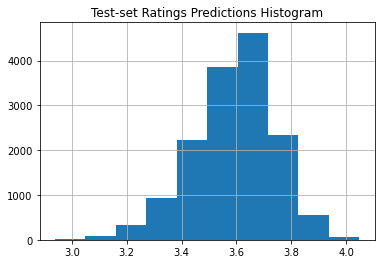

In [309]:
testset_eval_ens['pred_mean'].hist()
plt.title('Test-set Ratings Predictions Histogram');

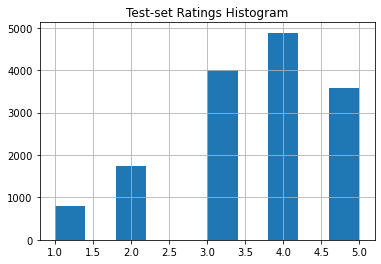

In [311]:
testset_eval_ens['rating'].hist()
plt.title('Test-set Ratings Histogram');

In [77]:
# from sklearn.decomposition import NMF
# kmeans_movies = NMF(n_components=30, init='random', random_state=0)
# kmeans_movies_fit = kmeans_movies.fit_transform(movies.drop(columns=['movie id']).fillna(0).values)
# movies_labels = np.argmin(kmeans_movies_fit, axis=1)
# nmf_users = NMF(n_components=20, init='random', random_state=0)
# nmf_users_fit = nmf_users.fit_transform(users.drop(columns=['user id']).fillna(0).values)
# users_labels = np.argmin(nmf_users_fit, axis=1)

## Plotting Clusters

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def scatter3d(x,y,z,colors, title):
    fig = plt.figure()
    ax = Axes3D(fig)
    graph = ax.scatter(x,y,z,c=colors, cmap='hsv') #  bwr
    plt.colorbar(graph)
    plt.title(title)
    plt.show()
    
def visualizeClusters(cluster_data, colors=None, title='Clusters'):
    if cluster_data.shape[1] != 3:
        pca_model = PCA(n_components=3)
        cluster_data = pca_model.fit_transform(cluster_data.fillna(0))
        
    scatter3d(cluster_data[:,0],cluster_data[:,1],cluster_data[:,2],colors, title)

In [33]:
kmeans_users, kmeans_movies = getTrainClusterModels(movies, users, n_clusters_movies=30, n_clusters_users=30)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


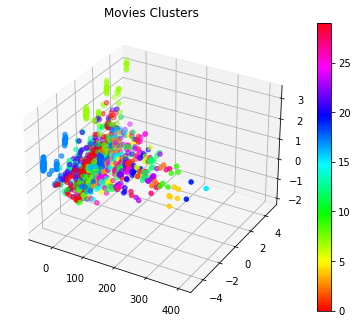

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


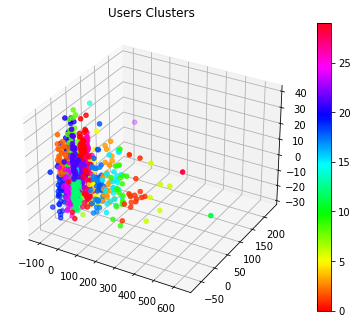

In [34]:
# visualizeClusters(movies, colors=pd.Series(kmeans.labels_).values)
visualizeClusters(movies, colors=kmeans_movies.labels_, title='Movies Clusters');
visualizeClusters(users, colors=kmeans_users.labels_, title='Users Clusters');

In [20]:
# users = df.pivot_table(index='user_id', columns='item_id', values='rating')

In [90]:
from sklearn.cluster import SpectralClustering

In [92]:
spectral = SpectralClustering(n_clusters=30)
spectral_fit = spectral.fit(movies.fillna(0).values)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


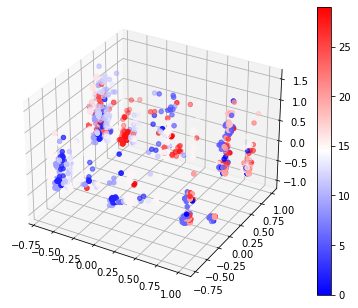

In [93]:
visualizeClusters(movies, colors=pd.Series(spectral.labels_).values)